# Load raw data and prepare train set

In [140]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [80]:
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 400
pd.options.display.max_seq_items = 200
pd.set_option('display.max_colwidth', 200)

## Utility Functions

In [102]:
def remove_return_code(df):
    # Remove return codes
    df['text'] = df['text'].map(lambda x: x.replace('\n','').replace('\r',''))
    # df['contents'] = df['contents'].map(lambda x: re.sub('(\. )(\. )+', '. ', x))

def add_word_count(df):
    df['word_count'] = None
    for i in tqdm(range(len(df))):
        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(input_words)

def separate_sections(df):
    df['text_sections'] = None
    for i in range(len(df)):
        df['text_sections'][i] = df['text'][i].split("[SECTION]")
        
def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

def get_rate(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return float(statements['Rate'][i])
        return None

In [104]:
def remove_short_section(df, min_words=50):
    for i in tqdm(range(len(df))):
        contents_bk_0 = df["text"][i]
        contents_bk_20 = ""
        df["text"][i] = ""
        for section in df["text_sections"][i]:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section.lower())
            num_words = len(words)
            if num_words > min_words:
                df["text"][i] += section
            if num_words > 20:
                contents_bk_20 += section
        # Fall back
        if df["text"][i] == "":
            if contents_bk_20 =="":
                df["text"][i] = contents_bk_0
            else:
                df["text"][i] = contents_bk_20

        # Update the word count
        words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(words)


In [111]:
def get_split(text, split_len=150, overlap=50):
    l_total = []
    l_parcial = []
    if len(text.split())//split_len >0:
        n = len(text.split())//split_len
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:(split_len+overlap)]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*split_len:w*split_len + (split_len+overlap)]
            l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=150, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), desc='Looping dataframe'):
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            split_data_list.append([text, row.target, row.rate, row.date, row.type])
            
    split_df = pd.DataFrame(split_data_list, columns=['text', 'target', 'rate', 'date', 'type'])
    return split_df
    

In [106]:
def one_hot_encode(df):
    df['target_lower'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
    df['target_hold'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
    df['target_raise'] = df['target'].apply(lambda x: 1 if x == 2 else 0)


## Statements

In [85]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents,speaker,title
Date,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement


In [86]:
print(statements.contents[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Load FED Rate Data
First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [47]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [48]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


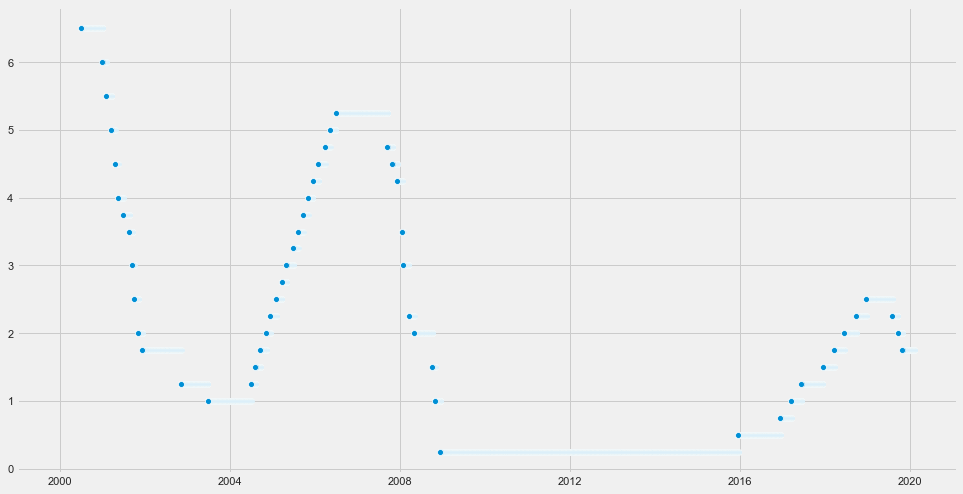

In [49]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2020.

So, again download from FRB of St. Louis (https://fred.stlouisfed.org/categories/118).

In [50]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARL.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARU.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.250
1982-09-28,10.250
1982-09-29,10.250
1982-09-30,10.250
1982-10-01,10.000
1982-10-02,10.000
1982-10-03,10.000
1982-10-04,10.000
1982-10-05,10.000


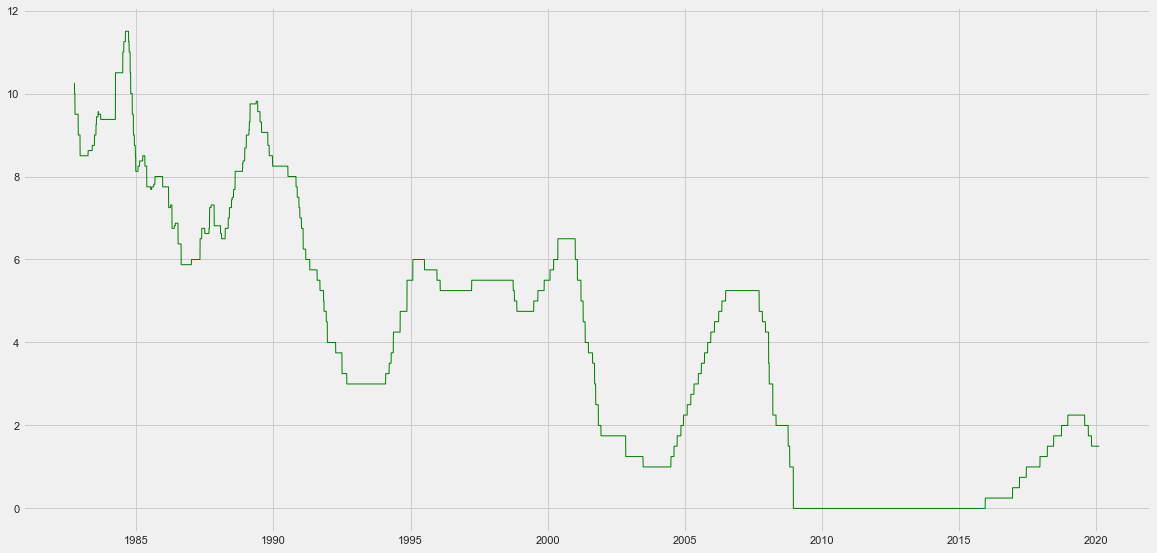

In [51]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Map Rate Decisions to Statements

In [87]:
statements['RateChange'] = None
statements['Rate'] = None

for i in range(len(statements)):
    for j in range(len(fedrate_df)):
        if statements.index[i] == fedrate_df.index[j]:
            statements['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 2
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 0

statements.head(10)

,contents,speaker,title,RateChange,Rate
Date,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement,2,3.25
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement,2,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement,2,3.75
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement,2,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement,2,4.75
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement,2,5.5
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement,2,6
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement,0,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement,0,5.5


In [88]:
statements.tail(10)

,contents,speaker,title,RateChange,Rate
Date,,,,,
2019-01-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.25
2019-03-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.25
2019-05-01,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.25
2019-06-19,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.25
2019-07-31,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,2
2019-09-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,1.75
2019-10-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,1.75
2019-10-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,1.5
2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,1.5


Looks good.
### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [91]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.
qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
          "to purchase the direct obligations of housing-related government-sponsored "\
          "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
          "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
          "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
          "have widened appreciably of late.  This action is being taken to reduce the cost "\
          "and increase the availability of credit for the purchase of houses, which in turn "\
          "should support housing markets and foster improved conditions in financial markets "\
          "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
          "the program will be conducted with the Federal Reserve's primary dealers through "\
          "a series of competitive auctions and will begin next week.  Purchases of up to "\
          "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
          "process with a goal of beginning these purchases before year-end.  "\
          "Purchases of both direct obligations and MBS are expected to take place over "\
          "several quarters.  Further information regarding the operational details of this "\
          "program will be provided after consultation with market participants."
statements = statements.append(
    pd.Series([qe_text, 'Ben Bernanke', 'statement', 0, 0], index=statements.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)
statements.sort_index(inplace=True)

# Add the other times when additional quantitative measures were announced in the statement
statements.loc['2009-03-18', 'RateChange'] = 0
statements.loc['2010-11-03', 'RateChange'] = 0
statements.loc['2011-09-21', 'RateChange'] = 0
statements.loc['2012-06-20', 'RateChange'] = 0
statements.loc['2012-09-13', 'RateChange'] = 0

# It was announced QE ends
statements.loc['2013-12-18', 'RateChange'] = 2

In [92]:
statements.iloc[statements.index > dt.datetime.strptime('2008-11-20', '%Y-%m-%d')]

,contents,speaker,title,RateChange,Rate
Date,,,,,
2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,statement,0,0
2008-12-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0
2009-01-28,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0
2009-03-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0
2009-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0
2009-06-24,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0
2009-08-12,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0
2009-09-23,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0
2009-11-04,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0


## Statements DataFrame

In [107]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["statement"]*len(statements), index=statements.index),
    "text": statements["contents"],
    "date": statements.index,
    "speaker": statements["speaker"],
    "org_contents": statements["contents"],
    "target": statements["RateChange"],
    "rate": statements["Rate"]
}

statement_df = pd.DataFrame(dict)
statement_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(statement_df)
separate_sections(statement_df)
add_word_count(statement_df)
statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",103
1994-03-22,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",42
1994-04-18,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",39
1994-05-17,statement,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",165
1994-08-16,statement,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",142
1994-11-15,statement,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the 

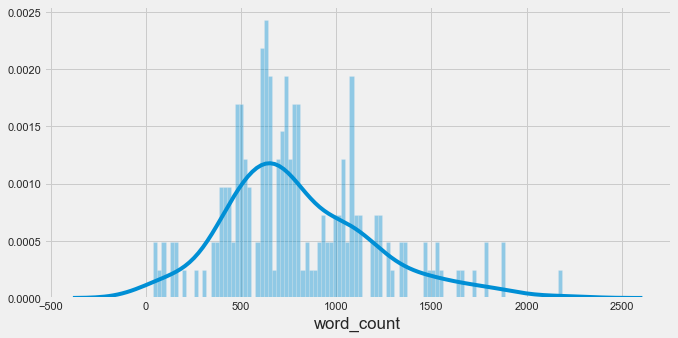

In [56]:
plt.figure(figsize=(10,5))
sns.distplot(statement_df["word_count"], bins=100)

In [108]:
remove_short_section(statement_df)

statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: S

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",99
1994-03-22,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",40
1994-04-18,statement,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",37
1994-05-17,statement,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",57
1994-08-16,statement,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",51
1994-11-15,statement,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the

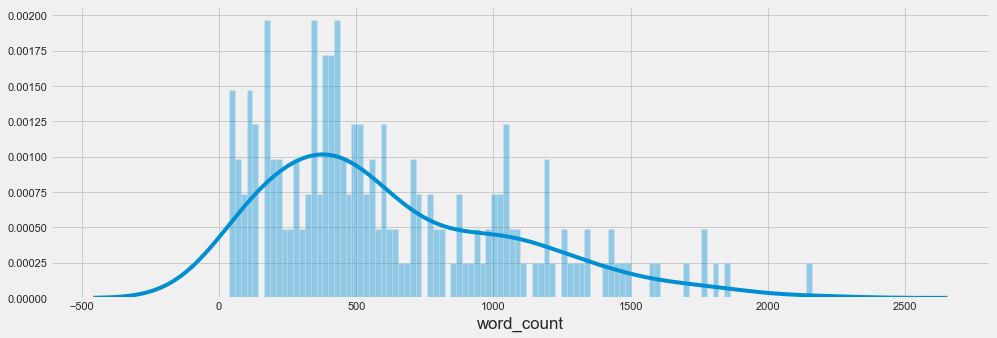

In [109]:
plt.figure(figsize=(15,5))
sns.distplot(statement_df["word_count"], bins=100)

### Split contents to max 200 words

In [112]:
stmt_split_df = get_split_df(statement_df)
stmt_split_df.tail()

,text,target,rate,date,type
722,"action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective are the most li...",1,1.75,2019-10-11,statement
723,Information received since the Federal Open Market Committee met in July indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains hav...,0,1.50,2019-10-30,statement
724,"action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective are the most li...",0,1.50,2019-10-30,statement
725,Information received since the Federal Open Market Committee met in October indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains ...,1,1.50,2019-12-11,statement
726,Information received since the Federal Open Market Committee met in December indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains...,1,1.50,2020-01-29,statement


## Minutes DataFrame

In [113]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'
minutes_df.head()

,contents,speaker,title
Date,,,
1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,minutes
1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,minutes
1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,minutes
1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,minutes
1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,minutes


In [114]:
print(minutes_df["contents"][-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

In [115]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["minutes"]*len(minutes_df), index=minutes_df.index),
    "text": minutes_df["contents"],
    "date": minutes_df.index,
    "speaker": minutes_df["speaker"],
    "org_contents": minutes_df["contents"],
    "target": minutes_df.index.map(get_rate_change),
    "rate": minutes_df.index.map(get_rate)
}

minutes_df = pd.DataFrame(dict)
minutes_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(minutes_df)
separate_sections(minutes_df)
add_word_count(minutes_df)
minutes_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, December 21, 1993, at 9:00 a.m.[...",1994-02-04,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 21, 1993, at 9:...",2.0,3.25,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, December 21, 1993, at 9:00 a.m....",5913
1994-03-22,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m.[SEC...",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m., P...",6456
1994-03-22,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m.[SEC...",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m., P...",6456
1994-05-17,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a.m.[SECTI...",1994-05-17,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",2.0,4.25,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a.m., PRE...",4989
1994-07-06,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30 ...",1994-07-06,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",2.0,4.75,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30...",6736
1994-08-16,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 16, 1994, at 9:00 a.m.[S...",1994-08-16,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",2.0,4.75,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 16, 1994, at 9:00

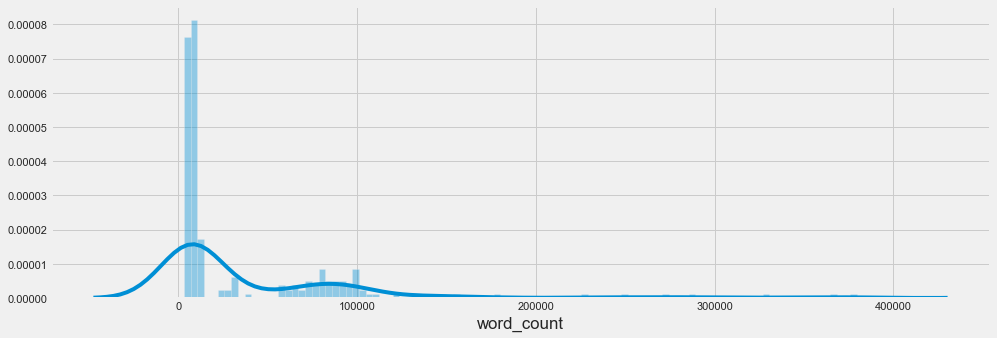

In [116]:
plt.figure(figsize=(15,5))
sns.distplot(minutes_df["word_count"], bins=100)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


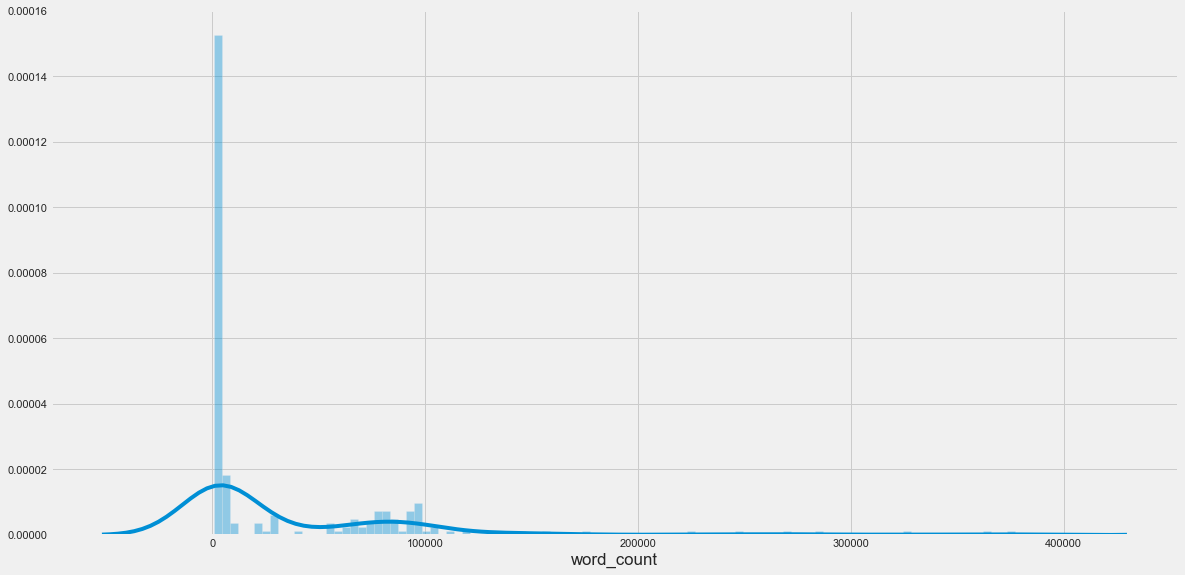

In [117]:
remove_short_section(minutes_df, 150)
sns.distplot(minutes_df["word_count"], bins=100)

### Split contents to max 200 words

In [118]:
minutes_split_df = get_split_df(minutes_df)
minutes_split_df.tail()

,text,target,rate,date,type
52841,"that equity, corporate debt, and CRE valuations were elevated and drew attention to high levels of corporate indebtedness and weak underwriting standards in leveraged loan markets. Some participan...",1.0,1.5,2020-01-29,minutes
52842,"migration of lending activities away from the U.S. banking sector to areas outside the oversight of federal banking supervisors.With regard to the Committee's price-stability objective, participan...",1.0,1.5,2020-01-29,minutes
52843,be below maximum employment and that maintaining the present monetary policy stance would allow the economy to achieve that maximum level. A couple of other participants expressed concern that tig...,1.0,1.5,2020-01-29,minutes
52844,"September 2019 and in ensuring continued control of the federal funds rate. Many participants stressed that, as reserves approached durably ample levels, the need for sizable Treasury bill purchas...",1.0,1.5,2020-01-29,minutes
52845,and maintaining ample reserves and that any adjustments to those operations were not intended to represent a change in the stance of monetary policy. Several participants suggested that the Commit...,1.0,1.5,2020-01-29,minutes


## Script DataFrame

In [176]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
script_df.head()

,contents,speaker,title
Date,,,
1990-02-07,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentlemen?\n\n[SEC...,Alan Greenspan,script
1990-03-27,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to tell!\n\n[SECTION]...,Alan Greenspan,script
1990-05-15,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\nCHAIRMAN GREE...,Alan Greenspan,script
1990-07-03,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there a sec...",Alan Greenspan,script
1990-08-21,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SEC...",Alan Greenspan,script


In [177]:
print(script_df['contents'][2])

CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?

[SECTION]

MS. SEGER. I'll move them.

[SECTION]

MR. KELLEY. Second.

[SECTION]

CHAIRMAN GREENSPAN. Without objection. Mr. Cross, would youbring us up to date on Desk operations?

[SECTION]

MR. CROSS. [Statement--see Appendix.]

[SECTION]

CHAIRMAN GREENSPAN. Questions for Mr. Cross? If there areno questions, would somebody like to move the ratification of histransactions since the last meeting?

[SECTION]

VICE CHAIRMAN CORRIGAN. So moved.

[SECTION]

SPEAKER(?). Second.

[SECTION]

CHAIRMAN GREENSPAN. Without objection. Mr. Sternlight.

[SECTION]

MR. STERNLIGHT. Thank you, Mr. Chairman. [Statement--seeAppendix.]

[SECTION]

CHAIRMAN GREENSPAN. Are there any questions for Mr.Sternlight?

[SECTION]

MR. HOSKINS. Peter, in March I asked about collateral toback the Federal Reserve notes. You thought there might be a problemin May, but I guess the Treasury balance situation solved that. Or doyou s

In [178]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["script"]*len(script_df), index=script_df.index),
    "text": script_df["contents"],
    "date": script_df.index,
    "speaker": script_df["speaker"],
    "org_contents": script_df["contents"],
    "target": script_df.index.map(get_rate_change),
    "rate": script_df.index.map(get_rate)
}

script_df = pd.DataFrame(dict)
script_df.dropna(subset=['target'], axis=0, inplace=True)

script_df.head(10)

,type,text,date,speaker,org_contents,target,rate
Date,,,,,,,
1994-02-04,script,"CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nomi...",1994-02-04,Alan Greenspan,"CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nomi...",2.0,3.25
1994-03-22,script,"CHAIRMAN GREENSPAN. Good morning everyone. We welcome CathyMinehan.\n\n[SECTION]\n\nMS. MINEHAN. Thank you, Mr. Chairman.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. I trust you won't dominate the meeting...",1994-03-22,Alan Greenspan,"CHAIRMAN GREENSPAN. Good morning everyone. We welcome CathyMinehan.\n\n[SECTION]\n\nMS. MINEHAN. Thank you, Mr. Chairman.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. I trust you won't dominate the meeting...",2.0,3.50
1994-05-17,script,CHAIRMAN GREENSPAN. Would somebody like to open the meetingby making a motion to approve the minutes?\n\n[SECTION]\n\nVICE CHAIRMAN MCDONOUGH. So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there...,1994-05-17,Alan Greenspan,CHAIRMAN GREENSPAN. Would somebody like to open the meetingby making a motion to approve the minutes?\n\n[SECTION]\n\nVICE CHAIRMAN MCDONOUGH. So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there...,2.0,4.25
1994-07-06,script,"CHAIRMAN GREENSPAN. Before we get started on our formalproceedings, I have several announcements. First, we'd like towelcome the new Vice Chairman of the Federal Reserve Board to hisfirst Federal ...",1994-07-06,Alan Greenspan,"CHAIRMAN GREENSPAN. Before we get started on our formalproceedings, I have several announcements. First, we'd like towelcome the new Vice Chairman of the Federal Reserve Board to hisfirst Federal ...",2.0,4.75
1994-08-16,script,"CHAIRMAN GREENSPAN. Before we get under way today, I want towelcome Governor Janet Yellen who is attending her first Committeemeeting.\n\n[SECTION]\n\nMS. YELLEN. Thank you.\n\n[SECTION]\n\nCHAIRM...",1994-08-16,Alan Greenspan,"CHAIRMAN GREENSPAN. Before we get under way today, I want towelcome Governor Janet Yellen who is attending her first Committeemeeting.\n\n[SECTION]\n\nMS. YELLEN. Thank you.\n\n[SECTION]\n\nCHAIRM...",2.0,4.75
1994-09-27,script,CHAIRMAN GREENSPAN. Who would like to move approval of theminutes for the August meeting?\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPA...,1994-09-27,Alan Greenspan,CHAIRMAN GREENSPAN. Who would like to move approval of theminutes for the August meeting?\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPA...,2.0,5.50
1994-11-15,script,"CHAIRMAN GREENSPAN. Good morning, everyone. We ought tocongratulate Governor Lindsey who has just returned without mishapfrom Rumania with an addition to his family.\n\n[SECTION]\n\nMR. LINDSEY. Y...",1994-11-15,Alan Greenspan,"CHAIRMAN GREENSPAN. Good morning, everyone. We ought tocongratulate Governor Lindsey who has just returned without mishapfrom Rumania with an addition to his family.\n\n[SECTION]\n\nMR. LINDSEY. Y...",2.0,5.50
1994-12-20,script,CHAIRMAN GREENSPAN. Would somebody like to move approval ofthe minutes for the meeting on November 15?\n\n[SECTION]\n\nVICE CHAIRMAN MCDONOUGH. So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Without...,1994-12-20,Alan Greenspan,CHAIRMAN GREENSPAN. Would somebody like to move approval ofthe minutes for the meeting on November 15?\n\n[SECTION]\n\nVICE CHAIRMAN MCDONOUGH. So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Without...,2.0,6.00
1995-02-01,script,"CHAIRMAN GREENSPAN. Good afternoon, everyone. The firstitem on the agenda is the election of officers and I turn the chairover to Governor Blinder.\n\n[SECTION]\n\nMR. BLINDER. For parliamentary r...",1995-02-01,Alan Greenspan,"CHAIRMAN GREENSPAN. Good afternoon, everyone. Th

### Split by speakers
Scripts contains words from different people, so split by the speaker

In [179]:
print(script_df.text[0])

CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nominations.

[SECTION]

MR. KELLEY. Mr. Chairman, I have the high honor and distinctprivilege to nominate officers to serve until the election of theirsuccessors at the first meeting of the Committee after December 31,1994. For Chairman of the Committee I nominate Alan Greenspan and forVice Chairman, William J. McDonough.

[SECTION]

SPEAKER(?). Second.

[SECTION]

MR. KELLEY. Thank you. I move the nominations cease.

[SECTION]

SPEAKER(?). Second.

[SECTION]

MR. KELLEY. You're a little slow but thank you! It's beenmoved and seconded and the nominations have ceased.

[SECTION]

CHAIRMAN GREENSPAN. The nominations have ceased and whathappens now?

[SECTION]

MR. KELLEY. I guess we vote. All in favor--do I do that?

[SECTION]

CHAIRMAN GREENSPAN. Yes, please carry on.

[SECTION]

MR. KELLEY. All i

In [197]:
script_data_list = []

for i, row in tqdm(script_df.iterrows(), desc='Looping dataframe'):
    text_list = row["text"].split("\n\n[SECTION]\n\n")
    for text in text_list:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, content = match[0]
            script_data_list.append([row.type, content, row.date, speaker, text, row.target, row.rate, ""])        
            
script_speaker_df = pd.DataFrame(script_data_list, columns=['type', 'text', 'date', 'speaker', 'org_contents', 'target', 'rate', 'text_sections'])

not matched:  SPEAKER(?). Second.
1994-02-04 00:00:00

not matched:  SPEAKER(?). Second.
1994-02-04 00:00:00

not matched:  MR. BERNARD.Secretary and Economist, Donald Kohn;Deputy Secretary, Normand Bernard;Assistant Secretaries, Joseph Coyne and Gary Gillum;General Counsel, J. Virgil Mattingly;Deputy General Counsel, Ernest Patrikis;Economists, Michael Prell and Edwin Truman.Associate Economists from the Board of Governors:David Lindsey;Larry Promisel;Charles Siegman;Thomas Simpson; and2/3-4/94David Stockton.Associate Economists from the Federal Reserve Banks:Jack Beebe, proposed by President Parry;John Davis, proposed by President Jordan;Richard Davis, proposed by President McDonough;Sheila Tschinkel, proposed by President Forrestal.That's the list, Mr. Chairman.
1994-02-04 00:00:00

not matched:  SPEAKER(?). So move.
1994-02-04 00:00:00

not matched:  SPEAKER(?). Second.
1994-02-04 00:00:00

not matched:  SPEAKER(?). So move.
1994-02-04 00:00:00

not matched:  SPEAKER(?). Second.
19

1995-02-01 00:00:00

not matched:  SPEAKER(?). But to whom are we committing? Are wecommitting to the Treasury or we are committing to the Mexicans? Ithink the whole thing does hang on the difference there. We can agreewith the Treasury and within the Committee as to what the rules are,but vis-a-vis our relations with the Mexicans and how we rewrite theswap agreements, etc.--
1995-02-01 00:00:00

not matched:  SPEAKER(?). Three months and we have to agree to renew. So,that may be the discipline which squares the circle.
1995-02-01 00:00:00

not matched:  SPEAKER(?). "Immoral" suasion!
1995-02-01 00:00:00

not matched:  MR. TRUMAN.-127-1/31-2/1/95
1995-02-01 00:00:00

not matched:  MR. TRUMAN.
1995-02-01 00:00:00

not matched:  SPEAKER(?). Have no standing or are from a differentpolitical party.
1995-02-01 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan YesVice Chairman McDonough YesGovernor Blinder YesPresident Hoenig YesGovernor Kelley YesGovernor LaWare May I ask a question?
1

not matched:  SPEAKER(?). Second.
1996-09-24 00:00:00

not matched:  SPEAKER(?). We could use the profits to support our"airforce"!
1996-09-24 00:00:00

not matched:  SPEAKER(?). Massachusetts! [Laughter]
1996-11-13 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan YesVice Chairman McDonough YesPresident Boehne YesPresident Jordan YesGovernor Kelley YesGovernor Lindsey YesPresident McTeer YesGovernor Meyer YesGovernor Phillips YesGovernor Rivlin YesPresident Stern YesGovernor Yellen Yes
1996-11-13 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan YesVice Chairman McDonough YesPresident Boehne YesPresident Jordan YesGovernor Kelley YesGovernor Lindsey YesPresident McTeer YesGovernor Meyer YesGovernor Phillips YesGovernor Rivlin YesPresident Stern YesGovernor Yellen Yes
1996-12-17 00:00:00

not matched:  SPEAKER(?). Second.
1997-02-05 00:00:00

not matched:  SPEAKER(?). Second.
1997-02-05 00:00:00

not matched:  SPEAKER(?). So move.
1997-02-05 00:00:00

not matched:  SPEAKER(?)

not matched:  SPEAKER(?).  Second. 
2000-06-28 00:00:00

not matched:  SPEAKER(?).  Second. 
2000-06-28 00:00:00

not matched:  SPEAKER(?)  I agree with you. 
2000-06-28 00:00:00

not matched:  END OF MEETING
2000-06-28 00:00:00

not matched:  SPEAKER(?).  We’re okay, thanks. 
2000-08-22 00:00:00

not matched:  END OF MEETING
2000-08-22 00:00:00

not matched:  SPEAKER(?).  So move. 
2000-10-03 00:00:00

not matched:  SPEAKER(?).  Second. 
2000-10-03 00:00:00

not matched:  SPEAKER(?).  I like it the way it is. 
2000-10-03 00:00:00

not matched:  END OF MEETING
2000-10-03 00:00:00

not matched:  SPEAKER(?).  So move. 
2000-11-15 00:00:00

not matched:  SEVERAL(?).  Move approval. 
2000-11-15 00:00:00

not matched:  SPEAKER(?).  Amen! 
2000-11-15 00:00:00

not matched:  END OF MEETING
2000-11-15 00:00:00

not matched:  SPEAKER(?).  Second. 
2000-12-19 00:00:00

not matched:  SPEAKER(?).  He is very predictable.  [Laughter] 
2000-12-19 00:00:00

not matched:  END OF MEETING
2000-12-19 00:

In [198]:
add_word_count(script_speaker_df)
script_speaker_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nominations.",1994-02-04,CHAIRMAN GREENSPAN,"CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nomi...",2.0,3.25,,30
1,script,"Mr. Chairman, I have the high honor and distinctprivilege to nominate officers to serve until the election of theirsuccessors at the first meeting of the Committee after December 31,1994. For Chai...",1994-02-04,MR. KELLEY,"MR. KELLEY. Mr. Chairman, I have the high honor and distinctprivilege to nominate officers to serve until the election of theirsuccessors at the first meeting of the Committee after December 31,19...",2.0,3.25,,43
2,script,Thank you. I move the nominations cease.,1994-02-04,MR. KELLEY,MR. KELLEY. Thank you. I move the nominations cease.,2.0,3.25,,7
3,script,You're a little slow but thank you! It's beenmoved and seconded and the nominations have ceased.,1994-02-04,MR. KELLEY,MR. KELLEY. You're a little slow but thank you! It's beenmoved and seconded and the nominations have ceased.,2.0,3.25,,17
4,script,The nominations have ceased and whathappens now?,1994-02-04,CHAIRMAN GREENSPAN,CHAIRMAN GREENSPAN. The nominations have ceased and whathappens now?,2.0,3.25,,7


(51975, 9)


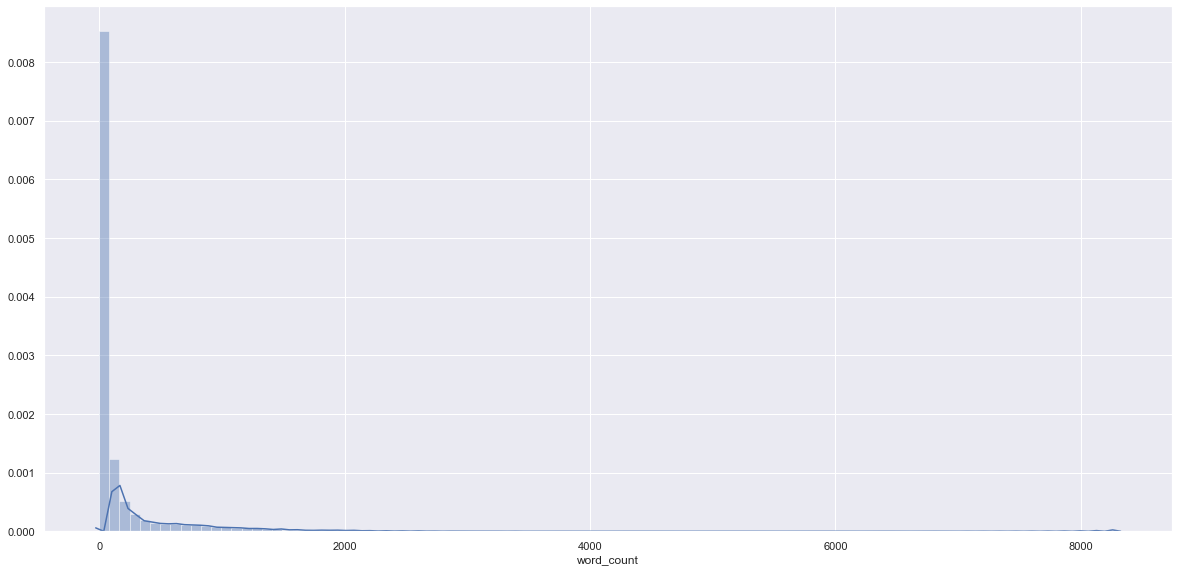

In [206]:
print(script_speaker_df.shape)
sns.distplot(script_speaker_df["word_count"], bins=100)

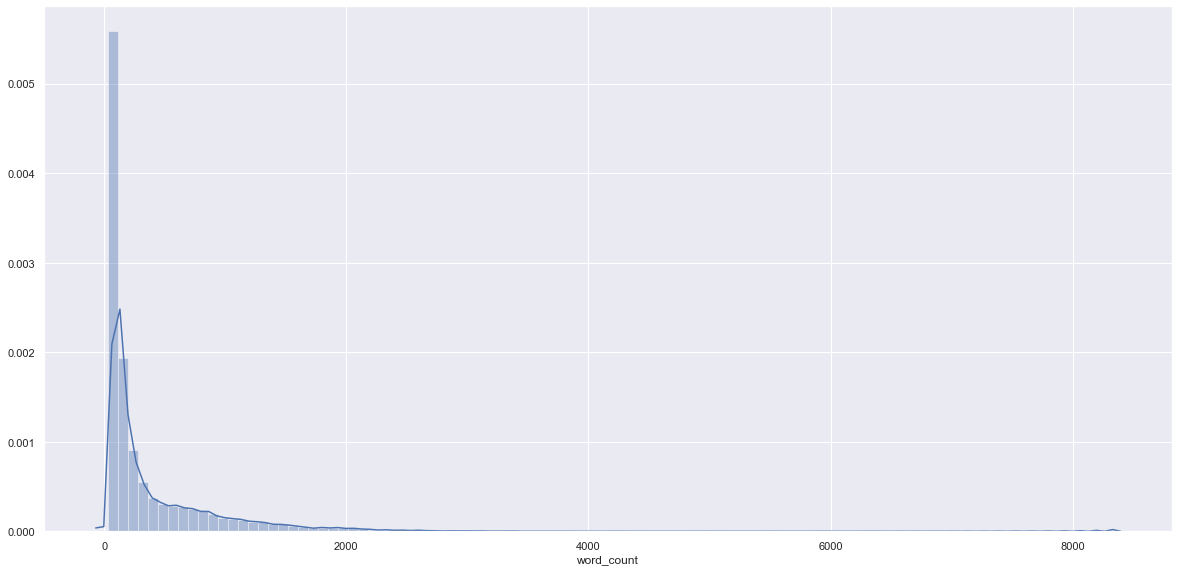

In [207]:
for i, row in tqdm(script_speaker_df.iterrows()):
    if row['word_count'] < 30:
        script_speaker_df.drop([i], axis=0, inplace=True)

sns.distplot(script_speaker_df["word_count"], bins=100)

In [208]:
script_speaker_df.shape

(23625, 9)

In [211]:
#script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN|YELLEN|BERNANKE|POWELL")]

script_greenspan = script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN")]
script_greenspan['speaker'] = 'Alan Greenspan'

script_bernanke = script_speaker_df[script_speaker_df['speaker'].str.contains("BERNANKE")]
script_bernanke['speaker'] = 'Ben Bernanke'

script_yellen = script_speaker_df[script_speaker_df['speaker'].str.contains("YELLEN")]
script_yellen['speaker'] = 'Janet Yellen'

script_powell = script_speaker_df[script_speaker_df['speaker'].str.contains("POWELL")]
script_powell['speaker'] = 'Jerome Powell'

script_gbyp_df = pd.concat([script_greenspan, script_bernanke, script_yellen, script_powell], ignore_index=True)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [213]:
script_gbyp_df.shape

(4324, 9)

### Split contents to max 200 words

In [214]:
script_split_df = get_split_df(script_gbyp_df)
script_split_df.tail()

,text,target,rate,date,type
9146,"moving up. It’s at low—low levels compared to what it was before the crisis. So not every household—but, in the aggregate, household debt is in a good place, a very good place. Business debt has b...",1.0,1.5,2020-01-29,script
9147,"So let me say that I think this is a good time to do—to update CRA, really, in a way that is a win–win both for the intended beneficiaries—low- and moderate-income communities—and also for banks t...",1.0,1.5,2020-01-29,script
9148,be able to. We spent a lot of time on research and analysis and looking at meaningful reform. You saw Governor Brainard’s recent speech presenting some of the thinking and the analysis. And we hav...,1.0,1.5,2020-01-29,script
9149,So I do agree that—the principles that he articulated of firm and fair supervision and effective transparency in communications. I also think it’s a good thing that we would have brighter lines to...,1.0,1.5,2020-01-29,script
9150,"Sure. So we—we are assigned a job by Congress, and that is to use our tools to pursue maximum employment and stable prices. And that’s what—that’s our focus. Now, monetary policy is a blunt instru...",1.0,1.5,2020-01-29,script


## Speech DataFrame

In [215]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
speech_df

,contents,speaker,title
Date,,,
1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n\n\n\n\n\n I am hon...",Chairman Alan Greenspan,Bank supervision in a world economy
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n\n\n\n\n\n\r\n\r\n\r\n ...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
1996-09-08,Monetary Policy Objectives and Strategy\n\r\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to ...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n\n\n\n\n\nSmall Business Is Big Business\n\r\n It is my pleasu...",Governor Lawrence B. Lindsey,Small business is big business
1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n\n\n\n\n\n\r\n ...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n\n\n\n\n\nHere We Go Again?\n\r\n\tThank you. It is a pleasure to b...",Governor Lawrence B. Lindsey,Here we go again?
1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n\n\n\n\n\nHow To Grow Faster\n\r\n It is my pleasure to be here today to dis...",Governor Lawrence B. Lindsey,How to grow faster


In [216]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["speech"]*len(speech_df), index=speech_df.index),
    "text": speech_df["contents"],
    "date": speech_df.index,
    "speaker": speech_df["speaker"],
    "org_contents": speech_df["contents"],
    "target": speech_df.index.map(get_rate_change),
    "rate": speech_df.index.map(get_rate)
}

speech_df = pd.DataFrame(dict)
speech_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(speech_df)
separate_sections(speech_df)
add_word_count(speech_df)
remove_short_section(speech_df, 50)

speech_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/yuki/anaconda3/lib/python3.7/site-packages

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1996-06-13,speech,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996 I am honored to present the Will...",1996-06-13,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n\n\n\n\n\n I am hon...",2.0,5.5,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996 I am honored to present the Wil...",57634
1996-06-18,speech,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996 It is a pleasure to be here this ...",1996-06-18,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n\n\n\n\n\n\r\n\r\n\r\n ...",2.0,5.5,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996 It is a pleasure to be here this...",28674
1996-09-08,speech,Monetary Policy Objectives and StrategyI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphas...,1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\r\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to ...,2.0,5.5,[Monetary Policy Objectives and StrategyI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to empha...,43853
1996-09-19,speech,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996 ...",1996-09-19,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",2.0,5.5,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996 ...",11973
1996-10-02,speech,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996Small Business Is Big Business It is my pleasure to be here today at the F...",1996-10-02,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n\n\n\n\n\nSmall Business Is Big Business\n\r\n It is my pleasu...",2.0,5.5,"[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996Small Business Is Big Business It is my pleasure to be here today at the ...",11705
1996-10-05,speech,"Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996 You may well wonder why a...",1996-10-05,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n\n\n\n\n\n\r\n ...",2.0,5.5,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii Octo

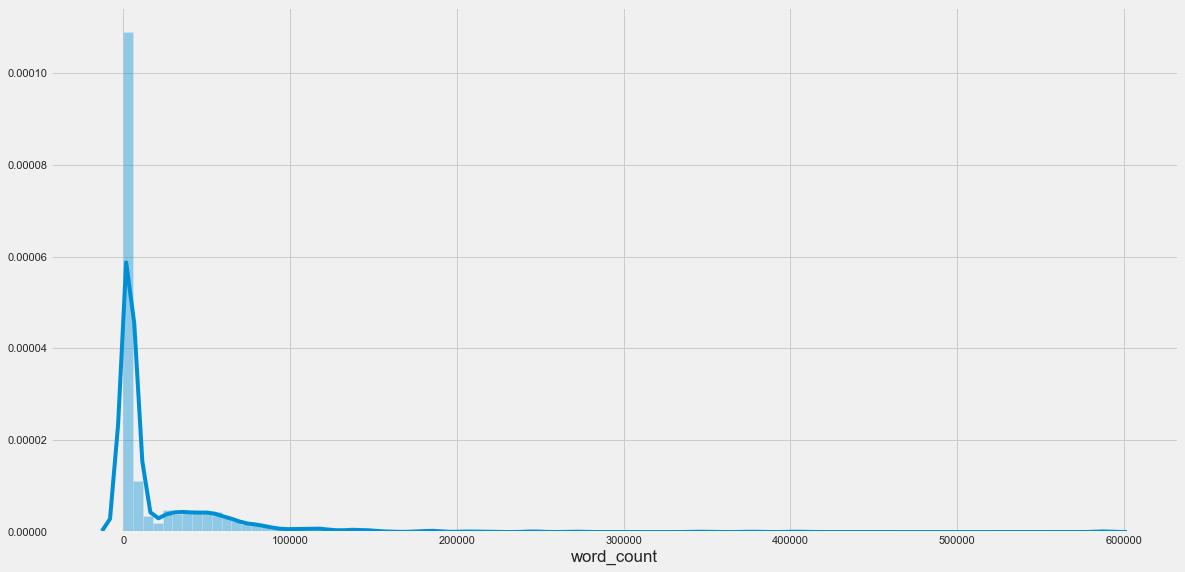

In [73]:
sns.distplot(speech_df["word_count"], bins=100)

In [218]:
speech_df.shape

(1447, 9)

In [221]:
speech_greenspan = speech_df[speech_df['speaker'].str.contains("GREENSPAN|Greenspan|greenspan")]
speech_greenspan['speaker'] = 'Alan Greenspan'

speech_bernanke = speech_df[speech_df['speaker'].str.contains("BERNANKE|Bernanke|bernanke")]
speech_bernanke['speaker'] = 'Ben Bernanke'

speech_yellen = speech_df[speech_df['speaker'].str.contains("YELLEN|Yellen|yellen")]
speech_yellen['speaker'] = 'Janet Yellen'

speech_powell = speech_df[speech_df['speaker'].str.contains("POWELL|Powell|powell")]
speech_powell['speaker'] = 'Jerome Powell'

speech_gbyp_df = pd.concat([speech_greenspan, speech_bernanke, speech_yellen, speech_powell], ignore_index=True)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [223]:
speech_gbyp_df.shape

(504, 9)

### Split contents to max 200 words

In [224]:
speech_split_df = get_split_df(speech_gbyp_df)
speech_split_df.tail()

,text,target,rate,date,type
51279,better chapters to their lives. These stories show clearly in the job market data. Employment gains have been broad based across all racial and ethnic groups and all levels of educational attainme...,1.0,1.5,2019-11-26,speech
51280,contributed to a 2 percentage point overall decline. Our falling participation rate stands out among advanced economies. While the United States was roughly in the middle of the pack among 32 econ...,1.0,1.5,2019-11-26,speech
51281,"20 percent rose only modestly. Since then, incomes for these groups have risen more rapidly, as wage growth has picked up—and picked up most for the lower-paying jobs (figure 7).Recent years' data...",1.0,1.5,2019-11-26,speech
51282,"lives of workers and families directly affected and to the strength of the economy overall. Of course, the task of evaluating the costs and benefits of these policies falls to our elected represen...",1.0,1.5,2019-11-26,speech
51283,"System, August 30). To view or download the data, see the interactive visualization tool at https://www.federalreserve.gov/releases/z1/dataviz/dfa/index.html. Return to text3. The Fed's real-time ...",1.0,1.5,2019-11-26,speech


In [225]:
speech_split_df.shape

(51284, 5)

## Combine DataFrames and Save

### All Data, before splitting

In [227]:
frames = [statement_df, minutes_df, script_df, speech_df]

df = pd.concat(frames, sort=True)
one_hot_encode(df)
df.reset_index(inplace=True, drop=True)
df.drop(columns=['text_sections', 'org_contents'], inplace=True)
df.rename(columns={'contents': 'text'}, inplace=True)

print(df.shape)
df.head(10)

,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,statement,99,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,statement,40,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,statement,37,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",statement,57,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",statement,51,0,0,1
5,1994-11-15,5.5,Alan Greenspan,2,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...",statement,121,0,0,1
6,1995-02-01,6,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Chicago, St. Louis, Kansas City and San ...",statement,54,0,0,1
7,1995-07-06,5.75,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve positions.Since the last easing of monetary policy in ...,statement,81,1,0,0
8,1995-12-19,5.5,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank reserve positions.As a result of the monetary tightening ...,statement,67,1,0,0
9,1996-01-31,5.25,Alan Greenspan,0,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...",statement,391,1,0,0


In [232]:
print(df.shape)

(2047, 10)


In [228]:
with open("../data/FOMC/train_all_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_all_df.csv', index=True)

### Split statement, scripts and speech by chairperson only
Do not use minutes for now.

In [229]:
split_frame = [stmt_split_df, script_split_df, speech_split_df]

split_df = pd.concat(split_frame, ignore_index=True, sort=True)
one_hot_encode(split_df)
split_df['target'] = split_df['target'].map(lambda x: int(x))
add_word_count(split_df)
#split_df.rename(columns={'contents': 'text'}, inplace=True)

print(split_df.shape)
split_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,rate,target,text,type,target_lower,target_hold,target_raise,word_count
0,1994-02-04,3.25,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,statement,0,0,1,99
1,1994-03-22,3.50,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,statement,0,0,1,40
2,1994-04-18,3.75,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,statement,0,0,1,37
3,1994-05-17,4.25,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",statement,0,0,1,57
4,1994-08-16,4.75,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",statement,0,0,1,51
5,1994-11-15,5.50,2,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...",statement,0,0,1,121
6,1995-02-01,6.00,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Chicago, St. Louis, Kansas City and San ...",statement,0,0,1,54
7,1995-07-06,5.75,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve positions.Since the last easing of monetary policy in ...,statement,1,0,0,81
8,1995-12-19,5.50,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank reserve positions.As a result of the monetary tightening ...,statement,1,0,0,67
9,1996-01-31,5.25,0,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...",statement,1,0,0,200


In [230]:
with open("../data/FOMC/train_split_df.pickle", "wb") as file:
    pickle.dump(split_df, file)

# In case pickle is not available
split_df.to_csv('../data/FOMC/train_split_df.csv', index=True)

In [231]:
print(split_df.shape)

(61162, 9)
